Text(0, 0.5, 'Price')

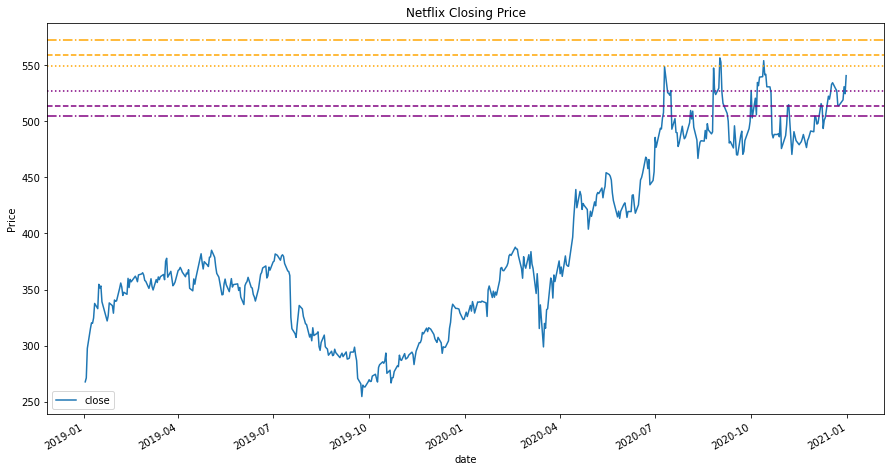

In [1]:
#1
#Using the StockAnalyzer and StockVisualizer classes, calculate and plot three levels of support and resistance for 
#Netflix's closing price.
%matplotlib inline
import itertools
import stock_analysis
from stock_analysis.utils import group_stocks


reader = stock_analysis.StockReader('2019-01-01', '2020-12-31')


bitcoin = reader.get_bitcoin_data('USD')
fb, aapl, amzn, nflx, goog = (reader.get_ticker_data(ticker) for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG'])
sp = reader.get_index_data('S&P 500')

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

nflx_analyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (levels(nflx_analyzer, metric) for metric in ['support', 'resistance'])

nflx_viz = stock_analysis.StockVisualizer(nflx)
ax = nflx_viz.evolution_over_time('close', figsize=(15, 8), title='Netflix Closing Price')

for support, resistance, linestyle, level in zip(support_levels, resistance_levels, 
    [':', '--', '-.'], itertools.count(1)):
    nflx_viz.add_reference_line(ax, y=support, color='purple', linestyle=linestyle)
    nflx_viz.add_reference_line(ax,y=resistance, color='Orange', linestyle=linestyle)
ax.set_ylabel('Price')


array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

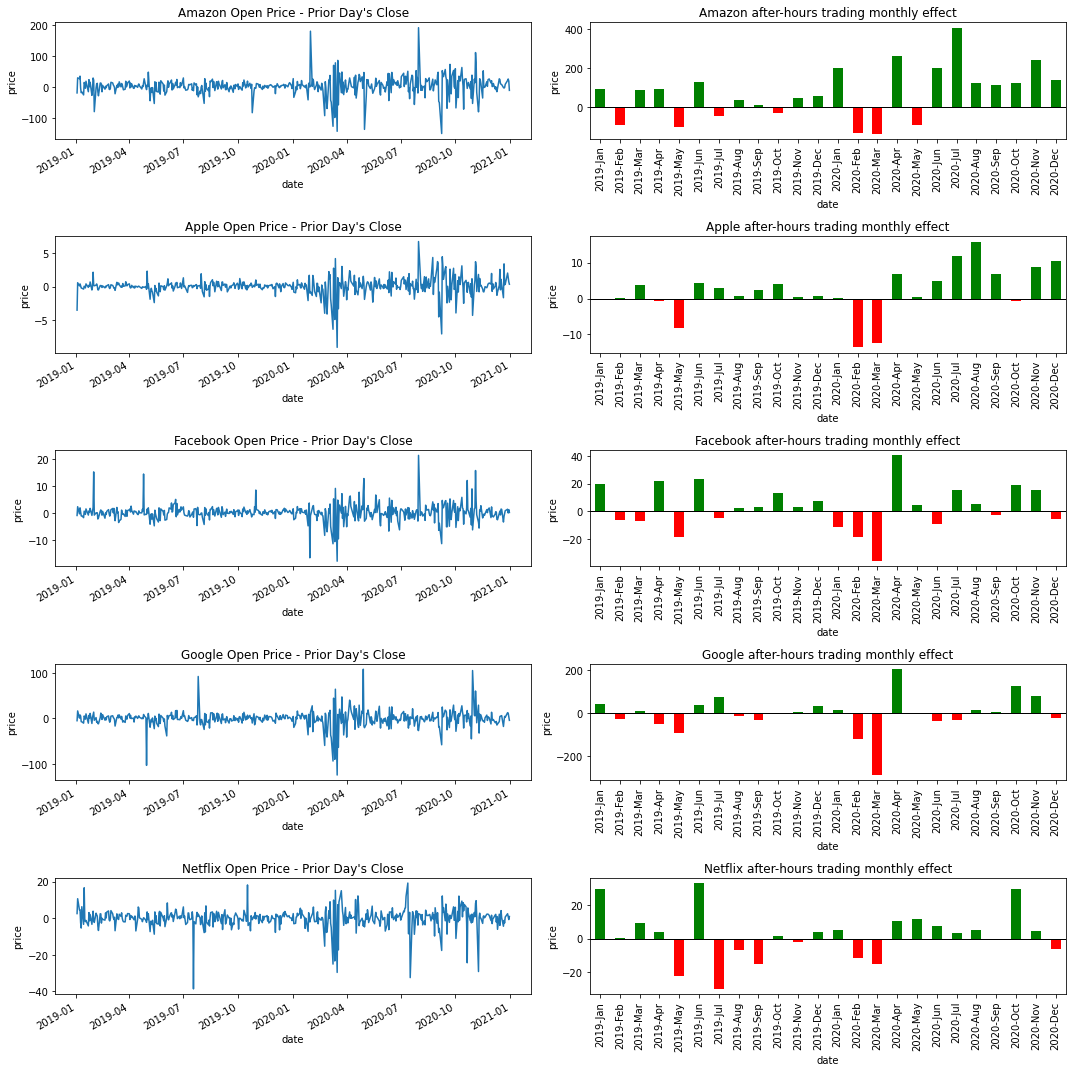

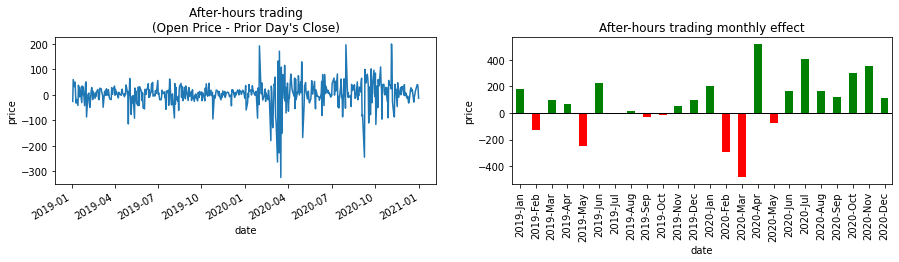

In [2]:
#2
#With the StockVisualizer class, look at the effect of after-hours trading on the FAANG stocks:
#a) As individual stocks
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()
#b) As a portfolio using the make_portfolio() function from the stock_analysis.utils module
from stock_analysis.utils import make_portfolio
stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()


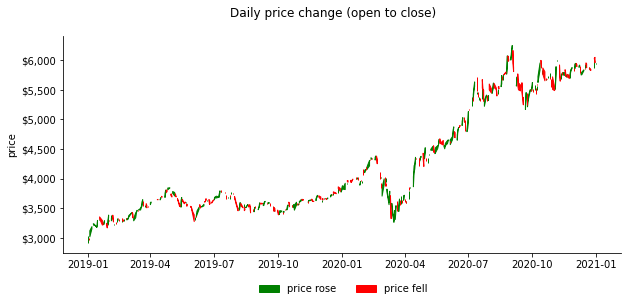

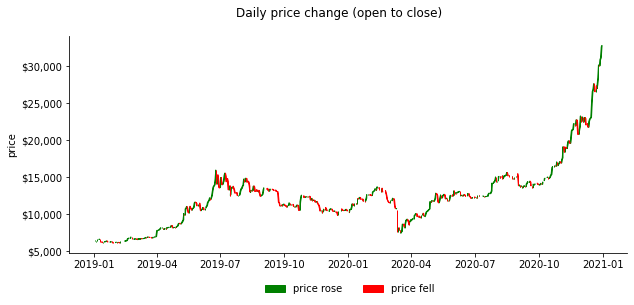

In [3]:
#3
#Using the StockVisualizer.open_to_close() method, create a plot that fills the area between the FAANG stocks' 
#opening price (as a portfolio) and its closing price each day in red if the price declined and in green if the price increased.

from matplotlib.ticker import StrMethodFormatter
from stock_analysis.utils import make_portfolio

ax = stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
#As a bonus, do the same for a portfolio of bitcoin and the S&P 500.
import pandas
import numpy

def bonus(data):
    out = data.copy().reindex(pandas.date_range('2019-01-01', end='2020-12-31', freq='D')).assign(
        volume=lambda x: x.fillna(0),
        close=lambda x: x.fillna(method='ffill'),
        open=lambda x: x.open.combine_first(x.close),
        high=lambda x: x.high.combine_first(x.close),
        low=lambda x: x.low.combine_first(x.close))
    return out

sp = bonus(sp)
ax = stock_analysis.StockVisualizer(bitcoin + sp).open_to_close().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))



In [4]:
#4
#Compare a mutual fund or ETF of your choice to three of its largest stocks (by composition)
#using annualized volatility and the AssetGroupAnalyzer class.

VTTSX = reader.get_ticker_data('VTTSX')
msft = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({
    'VTTSX': VTTSX,
    'Alphabet': goog,
    'Apple': aapl,
    'Amazon': amzn
})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze('annualized_volatility')


{'Alphabet': 0.3833720603377728,
 'Amazon': 0.3851099077041784,
 'Apple': 0.4670809643500882,
 'VTTSX': 0.28642726962563064}

In [5]:
#5
#Write a function that returns a dataframe of one row with columns for alpha, beta, sharpe_ratio, annualized_volatility, 
#is_bear_market, and is_bull_market, which each contain the results of running the respective methods on a given stock using 
#the StockAnalyzer class. Dictionary comprehensions and the getattr() function, as used in the AssetGroupAnalyzer.analyze() 
#method, will be useful.

import pandas


def myFunction(stock, i, r_f):
    return pandas.DataFrame({
        metric: getattr(
            stock_analysis.StockAnalyzer(stock),metric)(**kwargs)
        for metric, kwargs in {
            'alpha': {'index': i, 'r_f': r_f}, 
            'beta': {'index': i}, 
            'sharpe_ratio': {'r_f': r_f},
            'annualized_volatility': {},
            'is_bear_market': {},
            'is_bull_market': {}
        }.items()}, index=range(1))


myFunction(VTTSX, sp, reader.get_risk_free_rate_of_return())

,alpha,beta,sharpe_ratio,annualized_volatility,is_bear_market,is_bull_market
0,NaN,1.255661,4.858914,0.286427,False,False


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

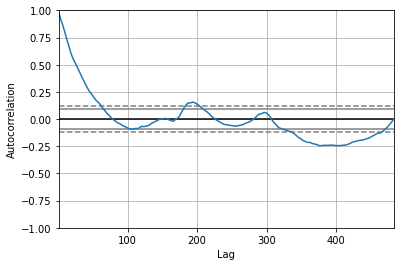

In [14]:
#6
#With the StockModeler class, build an ARIMA model fit on the S&P 500 data from January 1, 2019 through November 30, 2020 
#and use it to predict the performance in December 2020. Be sure to examine the residuals and compare the predicted
#performance to the actual performance.
train= sp['2019':'2020-11']
test = sp.loc['2020-12']
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train.close)

In [18]:
%%capture
from stock_analysis import StockModeler
arima_model = StockModeler.arima(train, ar=15, i=1, ma=5)

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

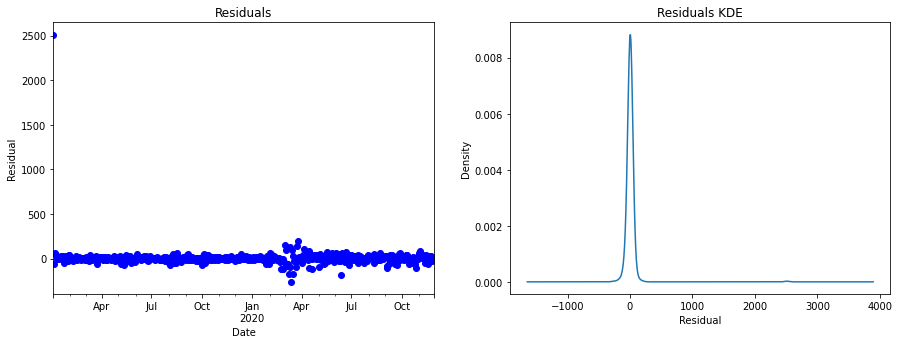

In [20]:
#for some reason this needs to be split up to two cells, or else it wont run
StockModeler.plot_residuals(arima_model)

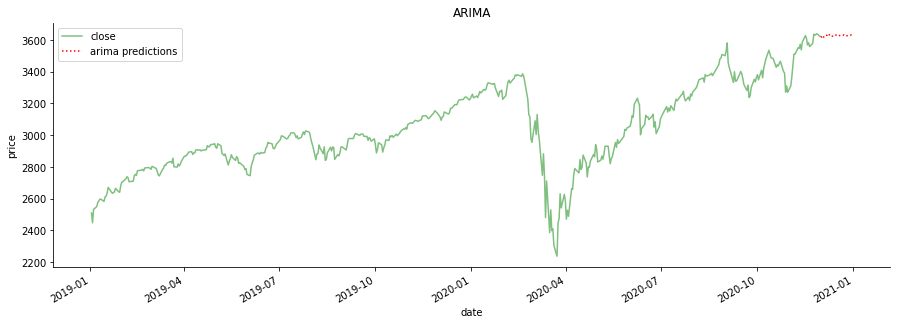

In [40]:
from matplotlib.ticker import EngFormatter

dates = test.index

ARIMA = StockModeler.arima_predictions(
    train, arima_model, start=dates[0], end=dates[-1],
    title='ARIMA', color='green', figsize=(15, 5), alpha=0.5
)
test.close.plot(ax=arima_ax, style='b--', label='actual close', alpha=0.5)

ARIMA.set_ylabel('price')

ARIMA.legend()

for spine in ['top', 'right']:ARIMA.spines[spine].set_visible(False)

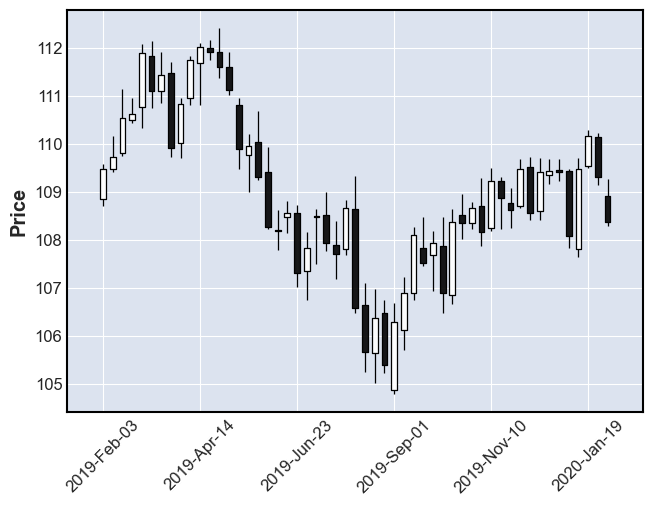

In [45]:
#7
#Request an API key for AlphaVantage (https://www.alphavantage.co/support/#api-key) and collect the daily foreign 
#exchange rate from USD to JPY using the get_forex_rates() method on the same StockReader object you created to collect 
#the data for the previous exercises. Build a candlestick plot with the data from February 2019 through January 2020,
#resampled to 1-week intervals. Hint: take a look at the slice() function from the standard library 
#(https://docs.python.org/3/library/functions.html#slice) in order to provide the date range.


forex = reader.get_forex_rates('USD', 'JPY', api_key='CZ32CX1XGLJEXVGV')
stock_analysis.StockVisualizer(forex).candlestick(date_range=slice('2019-02-01', '2020-01-31'), resample='1W')

